In [1]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.optim import Adam
from data_loading import process_text_df, NewsText, tensorize_sentences, collate_fn
from tqdm import tqdm as pbar
from models import NewsNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import matplotlib.pyplot as plt
import tqdm
stopwords = stopwords.words()
words = words.words() 
wordnet = wordnet.words()

In [2]:
fake, true = pd.read_csv('Fake.csv'), pd.read_csv('True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)

In [3]:
p1 = process_text_df(news, ['title', 'text'])

In [4]:
%%time
p1.process_text_col()

CPU times: user 2.84 s, sys: 1.26 s, total: 4.1 s
Wall time: 4min 20s


In [5]:
p1.df

,title,text,subject,date,label
0,"[russian, roulett, law, enforc, border, patrol...","[mind, blow, incompet, reckless, disregard, li...",left-news,"May 28, 2016",fake
1,"[trump, lead, republican, field, nation, 20, p...","[new, york, reuter, , donald, trump, taken, 20...",politicsNews,"February 18, 2016",true
2,"[polic, sight, larg, group, mask, antifa, cowa...","[watch, two, stun, interview, polic, offic, al...",left-news,"Apr 15, 2017",fake
3,"[trump, tax, cut, biggest, us, histori]","[washington, reuter, , presid, donald, trump, ...",politicsNews,"November 2, 2017",true
4,"[dozen, arrest, neonazi, march, sweden]","[gothenburg, sweden, reuter, , dozen, peopl, a...",worldnews,"September 30, 2017",true
...,...,...,...,...,...
44893,"[penc, say, make, strong, progress, republican...","[washington, reuter, , vice, presid, mike, pen...",politicsNews,"March 23, 2017",true
44894,"[trump, fight, releas, video, testimoni, fraud...","[new, york, reuter, , lawyer, republican, pres...",politicsNews,"June 13, 2016",true
44895,"[delusion, obama, blame, fake, news, hillari, ...",[],politics,"Nov 20, 2016",fake
44896,"[trump, campaign, chair, say, racism, didnt, e...","[presid, obama, right, appear, peopl, run, tru...",News,"September 22, 2016",fake


In [6]:
p1.tokenize_sentences()

In [7]:
l, labs = tensorize_sentences(p1.df.text.apply(lambda sent: sent[:50]), p1.df.label)

In [8]:
net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=5e-6)
idx = len(l) // 4

l_tr, labs_tr = l[:2 * idx], labs[:2 * idx]
l_val, labs_val = l[2 * idx:3 * idx], labs[2 * idx:3 * idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
tr_set = NewsText(l_tr, labs_tr)
val_set = NewsText(l_val, labs_val)
_, val_set = enumerate(DataLoader(val_set, batch_size=len(val_set), collate_fn=collate_fn)).__next__()
val_features, val_labels, val_lens = val_set
val_labels = val_labels.unsqueeze(-1).float()
loader = DataLoader(tr_set, batch_size=16, collate_fn=collate_fn)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 50
for i in range(epochs):
    print(f'Epoch {i + 1}')
    for sents, labels, lens in pbar(loader):
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents, lens)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features, val_lens)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
        
    loss_list.append(loss.item())

  0%|          | 5/1384 [00:00<00:31, 44.41it/s]

Epoch 1


  0%|          | 5/1384 [00:00<00:29, 47.24it/s]

Epoch 2


  0%|          | 5/1384 [00:00<00:27, 49.37it/s]

Epoch 3


  1%|          | 10/1384 [00:00<00:28, 48.43it/s]

Epoch 4


  1%|          | 10/1384 [00:00<00:28, 48.70it/s]

Epoch 5


  1%|          | 10/1384 [00:00<00:27, 49.75it/s]

Epoch 6


  0%|          | 6/1384 [00:00<00:27, 50.87it/s]

Epoch 7


  0%|          | 6/1384 [00:00<00:26, 51.12it/s]

Epoch 8


  0%|          | 5/1384 [00:00<00:27, 49.89it/s]

Epoch 9


  0%|          | 5/1384 [00:00<00:28, 48.76it/s]

Epoch 10


  1%|          | 10/1384 [00:00<00:27, 49.64it/s]

Epoch 11


  1%|          | 10/1384 [00:00<00:27, 49.23it/s]

Epoch 12


  0%|          | 6/1384 [00:00<00:27, 50.52it/s]

Epoch 13


  0%|          | 6/1384 [00:00<00:27, 49.73it/s]

Epoch 14


  1%|          | 10/1384 [00:00<00:27, 49.71it/s]

Epoch 15


  1%|          | 10/1384 [00:00<00:28, 49.05it/s]

Epoch 16


  1%|          | 10/1384 [00:00<00:27, 49.63it/s]

Epoch 17


  1%|          | 10/1384 [00:00<00:27, 49.63it/s]

Epoch 18


  1%|          | 10/1384 [00:00<00:27, 49.58it/s]

Epoch 19


  1%|          | 10/1384 [00:00<00:27, 49.40it/s]

Epoch 20


  0%|          | 5/1384 [00:00<00:27, 49.81it/s]

Epoch 21


  1%|          | 10/1384 [00:00<00:27, 49.77it/s]

Epoch 22


  0%|          | 6/1384 [00:00<00:27, 50.94it/s]

Epoch 23


  1%|          | 10/1384 [00:00<00:27, 49.22it/s]

Epoch 24


  0%|          | 5/1384 [00:00<00:27, 49.84it/s]

Epoch 25


  0%|          | 6/1384 [00:00<00:27, 51.03it/s]

Epoch 26


  1%|          | 10/1384 [00:00<00:27, 49.87it/s]

Epoch 27


  1%|          | 10/1384 [00:00<00:27, 49.64it/s]

Epoch 28


  0%|          | 5/1384 [00:00<00:27, 49.90it/s]

Epoch 29


  0%|          | 5/1384 [00:00<00:27, 49.98it/s]

Epoch 30


  1%|          | 10/1384 [00:00<00:27, 49.84it/s]

Epoch 31


  0%|          | 6/1384 [00:00<00:27, 50.42it/s]

Epoch 32


  0%|          | 5/1384 [00:00<00:28, 49.12it/s]

Epoch 33


  1%|          | 10/1384 [00:00<00:27, 49.47it/s]

Epoch 34


  0%|          | 5/1384 [00:00<00:27, 49.51it/s]

Epoch 35


  0%|          | 6/1384 [00:00<00:26, 51.24it/s]

Epoch 36


  0%|          | 5/1384 [00:00<00:28, 48.26it/s]

Epoch 37


  0%|          | 6/1384 [00:00<00:27, 50.88it/s]

Epoch 38


  0%|          | 6/1384 [00:00<00:27, 51.03it/s]

Epoch 39


  0%|          | 5/1384 [00:00<00:27, 49.97it/s]

Epoch 40


  0%|          | 6/1384 [00:00<00:26, 51.46it/s]

Epoch 41


  0%|          | 6/1384 [00:00<00:27, 50.44it/s]

Epoch 42


  0%|          | 6/1384 [00:00<00:27, 50.85it/s]

Epoch 43


  0%|          | 6/1384 [00:00<00:27, 50.94it/s]

Epoch 44


  0%|          | 6/1384 [00:00<00:27, 50.92it/s]

Epoch 45


  0%|          | 6/1384 [00:00<00:27, 50.61it/s]

Epoch 46


  0%|          | 6/1384 [00:00<00:27, 50.87it/s]

Epoch 47


  0%|          | 6/1384 [00:00<00:26, 51.35it/s]

Epoch 48


  0%|          | 6/1384 [00:00<00:26, 51.21it/s]

Epoch 49


  0%|          | 6/1384 [00:00<00:27, 50.46it/s]

Epoch 50


100%|██████████| 1384/1384 [00:26<00:00, 52.92it/s]


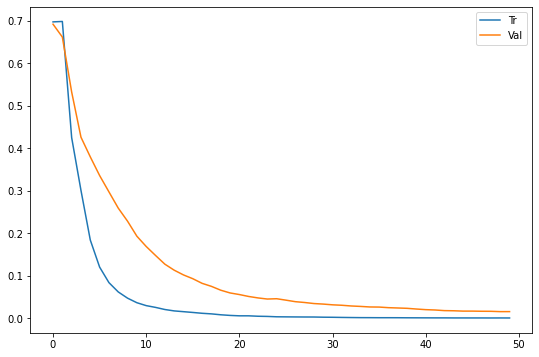

In [9]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

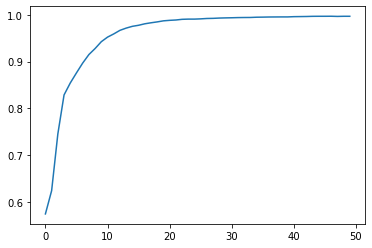

In [10]:
pd.Series(accuracy_list).plot()

In [11]:
tst_set = NewsText(l_tst, labs_tst)
_, tst_set = enumerate(DataLoader(tst_set, batch_size=len(tst_set), collate_fn=collate_fn)).__next__()
tst_features, tst_labels, test_lens = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [12]:
with torch.no_grad():
    tst_out = net(tst_features, test_lens)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [13]:
accuracy_tst

0.9985541105270386